In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from math import exp

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
sns.set_style("whitegrid")
sns.set_context("poster")
import pickle

In [3]:
movies_d = {}

In [4]:
def gen_sigmoid(t, a=-1.0,k=1.0,b=7.0,v=2.0,c=1.0,q=1.0):
    return a+(k-a)/((c+exp(-t*b)) ** (1/v))

In [5]:
def good_movie(name, views, max_views, user, reviewers, link, cutoff=7.5):
    user *= 2
    val = 2/(1/float(user)+1/float(reviewers)) * gen_sigmoid(float(views ** 0.5)/(max_views ** 0.5))
    return val, name, val>=cutoff, link

In [6]:
def add_movies(years):
    movies = []
    for year in years:
        driver = webdriver.Firefox()
        driver.maximize_window()

        wait = WebDriverWait(driver, 10)

        url = "http://www.rottentomatoes.com/"
        ext = "/top/bestofrt/?year="
        driver.get(url+ext+str(int(year)))

        # wait for the complete page load
        wait.until(EC.invisibility_of_element_located((By.ID, "preload")))

        # parse the HTML
        soup = BeautifulSoup(driver.page_source, "html.parser")
        #print(soup.find("table", class_ = "table"))

        driver.close()

        table = soup.find("table", class_ = "table")

        f = lambda x: (x['href'], " ".join(x.text.split(" ")[:-1]), int(x.text.split(" ")[-1][1:-1]))
        for t in table.find_all("tr")[1:]:
            link, name, year = f(t.a)
            movies.append([year, name, link])
                
    num = len(movies)
    for i, (y, n, l) in enumerate(movies):
        print "\r", (i+1)/float(num), n, url+l,
        soup_ = BeautifulSoup(requests.get(url+l).text, "html.parser")
        sp = soup_.find("div", id = "scorePanel")
        try:
            critics = float(sp.find("div", id = "scoreStats").div.text.split("/")[0][-3:])
            audience = [c.text.split(": ")[1] for c in sp.find("div", class_ = "audience-info").find_all("div")]
            audience[0] = float(audience[0].split("/")[0])
            audience[1] = int(audience[1].replace(',', ''))
            try:
                movies_d[y] = movies_d[y] + [(n, audience[1], audience[0], critics, url+l)]
            except KeyError:
                movies_d[y] = [(n, audience[1], audience[0], critics, url+l)]
        except:
            pass

In [7]:
while True:
    try:
        m = max(movies_d.keys())
    except:
        n = 1910
    else:
        del movies_d[m]
        n = m
    if n+11 > 2016:
        try:
            add_movies(range(n, 2016))
        except:
            pass
        else:
            break
    else:
        print n
        try:
            add_movies(range(n, n+11))
        except:
            pass

1910
1910
1.0 Das Cabinet des Dr. Caligari. (The Cabinet of Dr. Caligari) http://www.rottentomatoes.com//m/1003361-cabinet_of_dr_caligari/ 1920
1.0 All Quiet on the Western Front http://www.rottentomatoes.com//m/1000642-all_quiet_on_the_western_front/ 1930
1.0 Fantasia http://www.rottentomatoes.com//m/fantasia/ 1940
1.0 The Rules of the Game (La règle du jeu) http://www.rottentomatoes.com//m/the_rules_of_the_game/ 1950
1.0 The Apartment http://www.rottentomatoes.com//m/1001115-apartment/ 1960
1.0 Five Easy Pieces http://www.rottentomatoes.com//m/five_easy_pieces/ 1970
1.0 Cruising http://www.rottentomatoes.com//m/cruising/ 1980
1.0 The Bonfire of the Vanities http://www.rottentomatoes.com//m/bonfire_of_the_vanities/ 1990
1.0 The Family Man http://www.rottentomatoes.com//m/family_man/ 2000
1.0 Meru http://www.rottentomatoes.com//m/meru_2015/


In [205]:
with open('movies.pickle', 'wb') as handle:
    pickle.dump(movies_d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [206]:
with open('movies.pickle', 'rb') as handle:
    movies_d = pickle.load(handle)

In [207]:
movies = {}
blah = []
for k, v in movies_d.iteritems():
    m = max(zip(*v)[1])
    blah.append([k,[(v_, n, l) for n,v_,a,c,l in v]])
    for s,n,b,l in sorted([good_movie(n, v, m, a, c, l) for n, v, a, c, l in v], reverse=True):
        try:
            movies[k] = movies[k] + [(s,k,n,l)]
        except KeyError:
            movies[k] = [(s,k,n,l)]

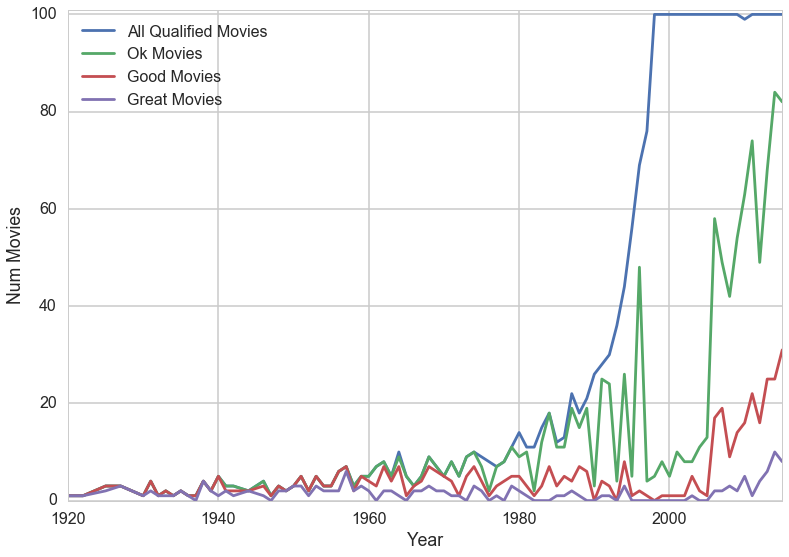

In [208]:
temps = []
cutoffs = [0, 5, 7, 8]
for k, v in movies.iteritems():
    temps.append([[k, len([s if s > cutoff else 0 for s,n,y,l in v if s > cutoff])] for cutoff in cutoffs])
    
names = ['All Qualified Movies','Ok Movies','Good Movies','Great Movies']
for n, temp in zip(names, zip(*temps)):    
    y, c = zip(*temp)
    plt.plot(y, c, label = n)
    plt.xlim(1920,2015)
    plt.ylim(0,101)
plt.xlabel("Year")
plt.ylabel("Num Movies")
plt.legend(loc = 2)
plt.savefig("Movies.png")

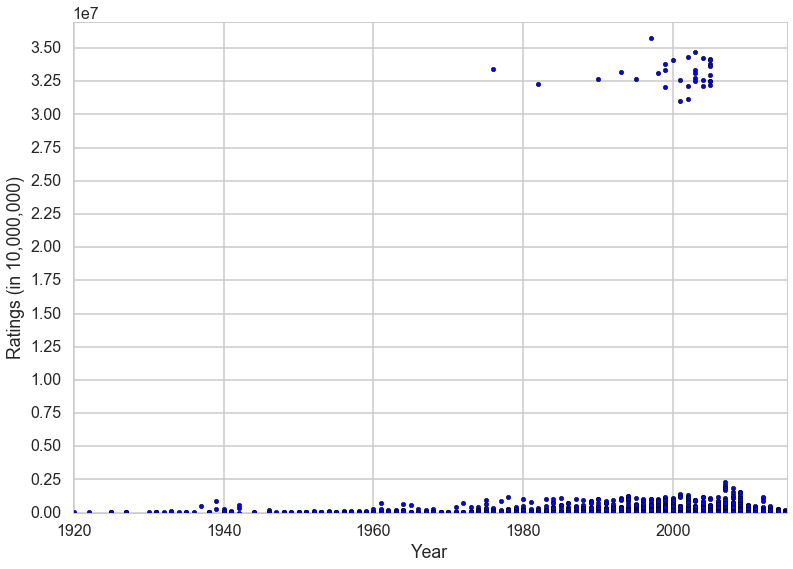

In [209]:
blah2 = [(v_, y, n, l)for y, v in blah for v_, n, l in v]
m,k,_,_ = zip(*blah2)
plt.scatter(k,m)
plt.xlim(1919.8,2015.2)
plt.ylim(0,37000000)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylabel("Ratings (in 10,000,000)")
plt.xlabel("Year")
plt.yticks(range(0,37000000,2500000))
plt.savefig("Ratings.png");

#### Most Viewed

In [210]:
for i,(a,b,c,d) in enumerate(sorted(blah2, reverse=True)[:40]):
    print i+1,a,b,c,d

1 35794266 1997 Titanic http://www.rottentomatoes.com//m/titanic/
2 34675072 2003 The Lord of the Rings: The Return of the King http://www.rottentomatoes.com//m/the_lord_of_the_rings_the_return_of_the_king/
3 34294122 2002 Spider-Man http://www.rottentomatoes.com//m/spiderman/
4 34230948 2004 Shrek 2 http://www.rottentomatoes.com//m/shrek_2/
5 34150708 2005 Harry Potter and the Goblet of Fire http://www.rottentomatoes.com//m/harry_potter_and_the_goblet_of_fire/
6 34125965 2000 Gladiator http://www.rottentomatoes.com//m/gladiator/
7 34103883 2005 The Chronicles of Narnia: The Lion, The Witch and The Wardrobe http://www.rottentomatoes.com//m/chronicles_of_narnia_lion_witch_wardrobe/
8 33780579 1999 American Pie http://www.rottentomatoes.com//m/american_pie/
9 33765187 2005 King Kong http://www.rottentomatoes.com//m/king_kong/
10 33676283 2005 Star Wars: Episode III - Revenge of the Sith http://www.rottentomatoes.com//m/star_wars_episode_iii_revenge_of_the_sith/
11 33402623 1976 Rocky htt

#### Best Movies

In [211]:
m = []
for k, v in movies.iteritems():
    for s,n,y,l in v:
        m.append((s,n,y,l))
        
for s, n, y, l in sorted(m, reverse=True)[:20]:
    print s,n,y,l

9.13920520646 1956 Seven Samurai (Shichinin no Samurai) http://www.rottentomatoes.com//m/seven_samurai_1956/
9.01939780736 1974 The Godfather, Part II http://www.rottentomatoes.com//m/godfather_part_ii/
8.98735827646 1972 The Godfather http://www.rottentomatoes.com//m/godfather/
8.97837922835 1931 M http://www.rottentomatoes.com//m/1012928-m/
8.92816955551 1950 Sunset Boulevard http://www.rottentomatoes.com//m/sunset_boulevard/
8.92816955551 1949 The Third Man http://www.rottentomatoes.com//m/the-third-man/
8.92307123867 1951 Rashômon (Rashomon) (In the Woods) http://www.rottentomatoes.com//m/rashomon/
8.90731872956 1931 City Lights http://www.rottentomatoes.com//m/city_lights/
8.82867375683 1950 All About Eve http://www.rottentomatoes.com//m/1000626-all_about_eve/
8.81001129609 1949 The Bicycle Thief http://www.rottentomatoes.com//m/the_bicycle_thief/
8.80431611434 1959 The 400 Blows (Les Quatre cents coups) http://www.rottentomatoes.com//m/400_blows/
8.78743961017 1936 Modern Times h

In [212]:
movies2 = {}
blah = []
for k, v in movies_d.iteritems():
    m = min(1000000,max(zip(*v)[1]))
    blah.append([k,[(v_, n, l) for n,v_,a,c,l in v]])
    for s,n,b,l in sorted([good_movie(n, v, m, a, c, l) for n, v, a, c, l in v], reverse=True):
        try:
            movies2[k] = movies2[k] + [(s,k,n,l)]
        except KeyError:
            movies2[k] = [(s,k,n,l)]

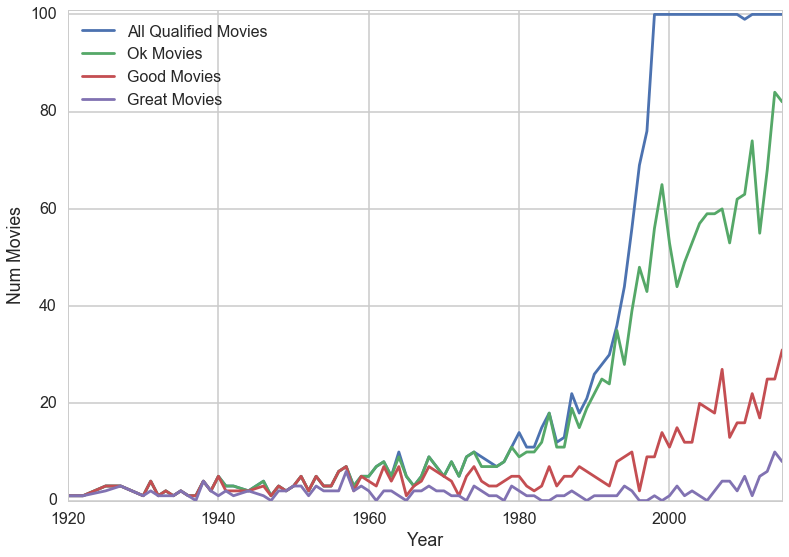

In [237]:
temps = []
cutoffs = [0, 5, 7, 8]
for k, v in movies2.iteritems():
    temps.append([[k, len([s if s > cutoff else 0 for s,n,y,l in v if s > cutoff])] for cutoff in cutoffs])
    
names = ['All Qualified Movies','Ok Movies','Good Movies','Great Movies']
for n, temp in zip(names, zip(*temps)):    
    y, c = zip(*temp)
    plt.plot(y, c, label = n)
    plt.xlim(1920,2015)
    plt.ylim(0,101)
plt.xlabel("Year")
plt.ylabel("Num Movies")
plt.legend(loc = 2)
plt.savefig("Movies2.png")

In [235]:
m2 = []
for k, v in movies2.iteritems():
    for s,n,y,l in v:
        m2.append((s,n,y,l))

c = 100
for i, ((s, y, n, l), (s2, y2, n2, l2)) in enumerate(zip(sorted(m, reverse=True)[:c]  ,  sorted(m2, reverse=True)[:c])):
    print i+1, s2, y2, n2, l2

1 9.13920520646 1956 Seven Samurai (Shichinin no Samurai) http://www.rottentomatoes.com//m/seven_samurai_1956/
2 9.01939780736 1974 The Godfather, Part II http://www.rottentomatoes.com//m/godfather_part_ii/
3 8.98735827646 1972 The Godfather http://www.rottentomatoes.com//m/godfather/
4 8.97837922835 1931 M http://www.rottentomatoes.com//m/1012928-m/
5 8.92816955551 1950 Sunset Boulevard http://www.rottentomatoes.com//m/sunset_boulevard/
6 8.92816955551 1949 The Third Man http://www.rottentomatoes.com//m/the-third-man/
7 8.92307123867 1951 Rashômon (Rashomon) (In the Woods) http://www.rottentomatoes.com//m/rashomon/
8 8.90731872956 1931 City Lights http://www.rottentomatoes.com//m/city_lights/
9 8.82867375683 1950 All About Eve http://www.rottentomatoes.com//m/1000626-all_about_eve/
10 8.81001129609 1949 The Bicycle Thief http://www.rottentomatoes.com//m/the_bicycle_thief/
11 8.80431611434 1959 The 400 Blows (Les Quatre cents coups) http://www.rottentomatoes.com//m/400_blows/
12 8.7874

In [272]:
def best(years, count=25, ind = True):
    try:
        [a for a in years]
    except TypeError:
        years = [years]
    output = []
    for y in years:
        try:
            v = movies2[y]
        except KeyError:
            pass
        else:
            for s,n,y,l in v:
                output.append((s,n,y,l))
    for i, (s, y, n, l) in enumerate(sorted(output, reverse=ind)[:count]):
        print i+1, s, y, n, l

In [283]:
best(2013, 1000, True)

1 8.59038666407 2013 12 Years a Slave http://www.rottentomatoes.com//m/12_years_a_slave/
2 8.43722975801 2013 Gravity http://www.rottentomatoes.com//m/gravity_2013/
3 8.19509717889 2013 Zero Dark Thirty http://www.rottentomatoes.com//m/zero_dark_thirty/
4 8.18687899055 2013 Captain Phillips http://www.rottentomatoes.com//m/captain_phillips/
5 8.09402912623 2013 Frozen http://www.rottentomatoes.com//m/frozen_2013/
6 8.00119007748 2013 The Hunger Games: Catching Fire http://www.rottentomatoes.com//m/the_hunger_games_catching_fire/
7 7.95141241411 2013 Star Trek Into Darkness http://www.rottentomatoes.com//m/star_trek_into_darkness/
8 7.90239176571 2013 Her http://www.rottentomatoes.com//m/her/
9 7.77368195161 2013 American Hustle http://www.rottentomatoes.com//m/american_hustle/
10 7.73669391402 2013 The Wolf of Wall Street http://www.rottentomatoes.com//m/the_wolf_of_wall_street_2013/
11 7.71713029632 2013 Dallas Buyers Club http://www.rottentomatoes.com//m/dallas_buyers_club_2013/
12 7

In [280]:
2/(1/6.7+1/8.6)

7.5320261437908504